In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pyarrow as pa

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import sys
print(sys.executable)

/Library/Frameworks/Python.framework/Versions/3.8/bin/python3


In [2]:
from utils import *

from feature_factory import add_feature_col_inplace, get_feature_col
from backtester import BackTester
# from strategy import basic_lin_regr_model1, monetization_strategy1

In [63]:

DATA_PATH = "historic_bybit/data"
trading_symbols = [
    'SILLYUSDT',
    'RSRUSDT'
]
symbols = trading_symbols + ['BTCUSDT']

df = get_combined_data(symbols, DATA_PATH)

# Feature Engineering
# add_return_cols_inplace(df, 'open', [5, 60, 1440])


symbol1 = "SILLYUSDT"
symbol2 = "RSRUSDT"

df.rename(columns={f'BTCUSDT_open': f'OpenPrice__BTCUSDT'}, inplace=True)

df.rename(columns={f'{symbol1}_open': f'OpenPrice__{symbol1}'}, inplace=True)
df.rename(columns={f'{symbol2}_open': f'OpenPrice__{symbol2}'}, inplace=True)
df.rename(columns={f'{symbol2}_volume': f'Volume__{symbol2}'}, inplace=True)


lin_regr_features = [
    f'Momentum__{symbol1}_1H',
    f'ZScore__{symbol1}_1H_5H',
    f'PriceChangeRate__{symbol1}_1H',
    f'ZScore__{symbol2}_1H_5H',
    f'ZScore__{symbol2}_1H_10H',
    f'VolumeMA__{symbol2}_1W',

    f'RollingBeta__{symbol1}_BTCUSDT_10080',
    f'RollingBeta__{symbol2}_BTCUSDT_10080',
]

for lin_regr_feature in lin_regr_features:
    add_feature_col_inplace(df, lin_regr_feature)

FEATURE = 'FutureLogReturn'

y_df = pd.DataFrame()
for symbol in symbols:
    feat = f'{FEATURE}__{symbol}_1H'
    y_df[feat] = get_feature_col(df, feat)

mn_df = pd.DataFrame()
for symbol in trading_symbols:
    mn_df[f'FutureLogReturn__{symbol}_1H_MN'] = y_df[f'{FEATURE}__{symbol}_1H'] - df[f'RollingBeta__{symbol}_BTCUSDT_10080'] * y_df[f'{FEATURE}__BTCUSDT_1H']
    
    def mappp(x):
        if x < -0.002:
            return -x
        elif x < 0.002:
            return 0.0
        else:
            return x

    
    mn_df[f'FutureLogReturn__{symbol}_1H_MN'] = mn_df[f'FutureLogReturn__{symbol}_1H_MN'].map(mappp)

print(df[lin_regr_features].columns)
print(y_df.columns)
print(mn_df.columns)
# print(mn_df.columns)

Index(['Momentum__SILLYUSDT_1H', 'ZScore__SILLYUSDT_1H_5H',
       'PriceChangeRate__SILLYUSDT_1H', 'ZScore__RSRUSDT_1H_5H',
       'ZScore__RSRUSDT_1H_10H', 'VolumeMA__RSRUSDT_1W',
       'RollingBeta__SILLYUSDT_BTCUSDT_10080',
       'RollingBeta__RSRUSDT_BTCUSDT_10080'],
      dtype='object')
Index(['FutureLogReturn__SILLYUSDT_1H', 'FutureLogReturn__RSRUSDT_1H',
       'FutureLogReturn__BTCUSDT_1H'],
      dtype='object')
Index(['FutureLogReturn__SILLYUSDT_1H_MN', 'FutureLogReturn__RSRUSDT_1H_MN'], dtype='object')


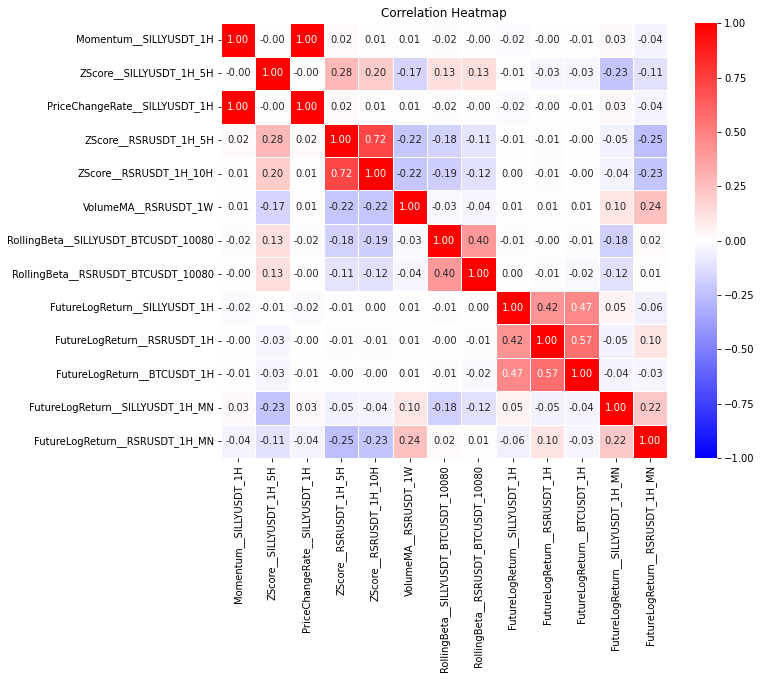

In [64]:

combined_df = pd.concat([df[lin_regr_features], y_df, mn_df], axis=1)


correlation_matrix = combined_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap='bwr',  # 'bwr' colormap for blue (-1), white (0), red (1)
    vmin=-1, vmax=1, 
    fmt=".2f", 
    linewidths=.5
)
plt.title("Correlation Heatmap")
plt.show()

In [65]:
def basic_lin_regr_model1(df, y_df, mn_df):

    feats = {'SILLYUSDT': ['Momentum__SILLYUSDT_1H', 'ZScore__SILLYUSDT_1H_5H',
       'PriceChangeRate__SILLYUSDT_1H'], 
       'RSRUSDT': ['ZScore__RSRUSDT_1H_5H',
       'ZScore__RSRUSDT_1H_10H', 'VolumeMA__RSRUSDT_1W']}

    symbols = ['SILLYUSDT', 'RSRUSDT']

    strategy_df = df.dropna().copy()

    for symbol in ['SILLYUSDT', 'RSRUSDT']:

        y_col = f'FutureLogReturn__{symbol}_1H_MN'

        datasets = get_datasets(df[feats[symbol]], mn_df, y_col)

        X_train, X_test, y_train, y_test = datasets
        test_start_date = X_test.index[0]

        model = get_LR_model(datasets)

        strategy_df.loc[:, f'{symbol}_signal'] = pd.Series(model.predict(strategy_df[feats[symbol]]), index=strategy_df.index)

        train_signal_std = strategy_df[strategy_df.index < test_start_date][f'{symbol}_signal'].std()

        strategy_df.loc[:, f'{symbol}_signal'] = strategy_df[f'{symbol}_signal'] / train_signal_std

        # strategy_df.loc[:, f'{symbol}_signal'] = mn_df[y_col]

    return strategy_df

def get_mapping_func(a1, a2, a3, a4):
    def get_ideal_pos(signal):
        if signal < a1:
            return -1.0
        elif signal < a2:
            return (signal - a2) / (a2 - a1)
        elif signal < a3:
            return 0.0
        elif signal < a4:
            return (signal - a3) / (a4 - a3)
        else:
            return 1.0
    return get_ideal_pos

def monetization_strategy1(strategy_df):

    backtest_df = pd.DataFrame()
    
    # RSRUSDT_mapping_func = get_mapping_func(-1.728, -0.815, 0.236, 1.062)
    # SILLYUSDT_mapping_func = get_mapping_func(-0.700, -0.170, 0.396, 1.252)

    RSRUSDT_mapping_func = np.sign
    SILLYUSDT_mapping_func = np.sign

    backtest_df['RSRUSDT_price'] = strategy_df['OpenPrice__RSRUSDT']
    backtest_df['SILLYUSDT_price'] = strategy_df['OpenPrice__SILLYUSDT']
    backtest_df['BTCUSDT_price'] = strategy_df['OpenPrice__BTCUSDT']

    backtest_df['RSRUSDT_pos'] = strategy_df['RSRUSDT_signal'].map(RSRUSDT_mapping_func)
    backtest_df['SILLYUSDT_pos'] = strategy_df['SILLYUSDT_signal'].map(SILLYUSDT_mapping_func)

    # trade every X minutes
    holding_minutes = 10
    mask = (backtest_df.reset_index().index.to_series().index % holding_minutes == 0)
    backtest_df['RSRUSDT_pos'] = backtest_df['RSRUSDT_pos'].where(mask, pd.NA).ffill()
    backtest_df['SILLYUSDT_pos'] = backtest_df['SILLYUSDT_pos'].where(mask, pd.NA).ffill()

    return backtest_df


MSE: 0.0003
R^2 score: 0.0551
train MSE: 0.0003
train R^2 score: 0.0533
MSE: 0.0000
R^2 score: -0.0227
train MSE: 0.0001
train R^2 score: 0.1046
ggs DatetimeIndex(['2024-02-08 04:59:00', '2024-02-08 05:00:00',
               '2024-02-08 05:01:00', '2024-02-08 05:02:00',
               '2024-02-08 05:03:00', '2024-02-08 05:04:00',
               '2024-02-08 05:05:00', '2024-02-08 05:06:00',
               '2024-02-08 05:07:00', '2024-02-08 05:08:00',
               ...
               '2024-11-13 04:51:00', '2024-11-13 04:52:00',
               '2024-11-13 04:53:00', '2024-11-13 04:54:00',
               '2024-11-13 04:55:00', '2024-11-13 04:56:00',
               '2024-11-13 04:57:00', '2024-11-13 04:58:00',
               '2024-11-13 04:59:00', '2024-11-13 05:00:00'],
              dtype='datetime64[ns]', name='time', length=401762, freq=None)
2024-11-13 05:00:00
2024-02-08 04:59:00
Train_test_cut:  2024-09-18 09:48:00


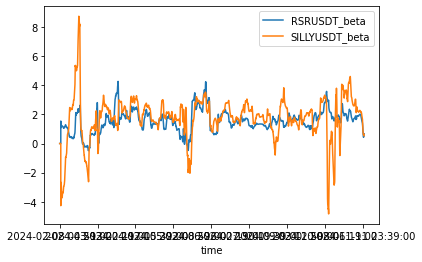

<Figure size 7200x5760 with 0 Axes>

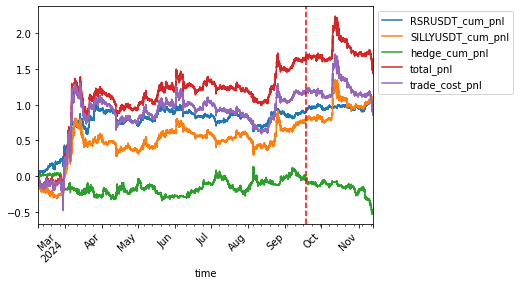

In [66]:
from backtester import BackTester
strategy_df = basic_lin_regr_model1(df, y_df, mn_df)
backtest_df = monetization_strategy1(strategy_df)
backTester = BackTester(backtest_df)
backTester.plot_individual_pnl()

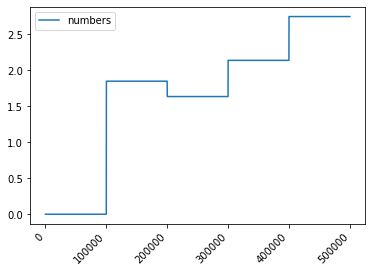

<Figure size 720x432 with 0 Axes>

0.7998616096096695
0.16945853515265258
0.03067985523767803


In [192]:
result_df = backTester.get_result_df()
# display(result_df)
# display(result_df.info())
# display(backtest_df.info())
# display((backtest_df[['SILLYUSDT_price','BTCUSDT_price']] == 0.0).sum())
# result_df[['BTCUSDT_actual_pos']].plot()
gg = pd.DataFrame()
X = 100000
gg['numbers'] = result_df['total_pnl'].iloc[::X].reset_index(drop=True).repeat(X).reset_index(drop=True)
gg.plot()
plt.xticks(rotation=45, ha='right')
plt.figure(figsize=(10, 6)) 
plt.show()

aa = backtest_df['RSRUSDT_pos']

print((aa==0.0).mean())
print((aa==1.0).mean())
print((aa==-1.0).mean())

In [96]:
ddd = pd.DataFrame()
ddd['hhh'] = backtest_df[f'{symbol}_pos'] * (1.0 / backtest_df[f'{symbol}_price']) # * (1.0 / (1+abs(beta_df[f'{symbol}_beta'])))

ddd.info()       

<class 'pandas.core.frame.DataFrame'>
Index: 401762 entries, 2024-02-08 04:59:00 to 2024-11-13 05:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   hhh     401762 non-null  float64
dtypes: float64(1)
memory usage: 14.2+ MB


<Axes: ylabel='Frequency'>

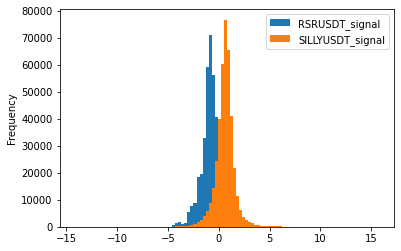

In [34]:
strategy_df[['RSRUSDT_signal', 'SILLYUSDT_signal']].plot(kind='hist', bins=100)

In [193]:
cols = ['RSRUSDT_signal', 'SILLYUSDT_signal']

for col in cols:
    # display(strategy_df[strategy_df[col] >= 0][col].describe(percentiles=[.1, .2, .3, .4, .5, .6, .7, .8, .9]))
    # display(strategy_df[strategy_df[col] <= 0][col].describe(percentiles=[.1, .2, .3, .4, .5, .6, .7, .8, .9]))
    
    a1 = strategy_df[strategy_df[col] <= 0][col].quantile(0.25)
    a2 = strategy_df[strategy_df[col] <= 0][col].quantile(0.75)
    
    a3 = strategy_df[strategy_df[col] >= 0][col].quantile(0.25)
    a4 = strategy_df[strategy_df[col] >= 0][col].quantile(0.75)
    print(col)
    print('[', ", ".join([f"{x:.3f}" for x in [a1, a2, a3, a4]]),']')

RSRUSDT_signal
[ -1.728, -0.815, 0.236, 1.062 ]
SILLYUSDT_signal
[ -0.700, -0.170, 0.396, 1.252 ]


<Axes: ylabel='Frequency'>

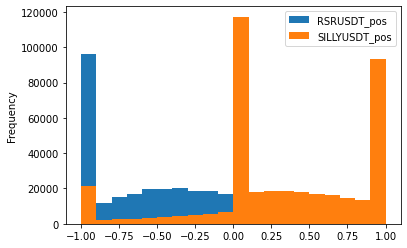

In [72]:
backtest_df[['RSRUSDT_pos', 'SILLYUSDT_pos']].plot(kind='hist', bins=20)

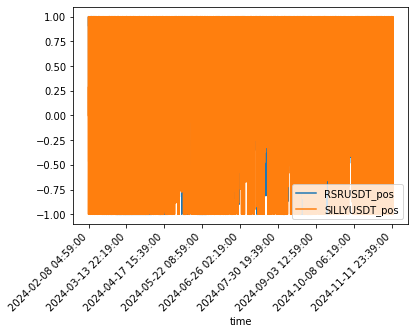

<Figure size 720x432 with 0 Axes>

In [75]:
backtest_df[['RSRUSDT_pos', 'SILLYUSDT_pos']].plot()
plt.xticks(rotation=45, ha='right')  # Rotate labels by 45 degrees and align to the right

# Optionally, adjust figure size
plt.figure(figsize=(10, 6))  # Change the size of the figure to make it more readable

# Show the plot
plt.show()